# Assignment 4

* In this assignment, you will train and evaluate vanilla RNN and LSTM/GRU
models for the task of performing sentiment classification (specifically, predicting
the sentiment of a short text).
* For the assignment we are using The Stanford Sentiment Treebank (SST-5) dataset to train and
test your models. 

In [35]:
#< import libraries>


# Get the interactive Tools for Matplotlib
#%matplotlib notebook
%matplotlib inline 
import matplotlib.pyplot as plt
#plt.style.use('')

from sklearn.decomposition import PCA

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
#from sklearn.metrics import roc_curve, auc
#from sklearn.metrics import roc_auc_score
import time

import torch
from torchtext import data
import torch.nn as nn

from pandas import DataFrame
import pandas as pd
import os

#It consists of 11,855 lines 
sentences extracted from movie reviews with one of five fine-grained sentiment
labels: 
1 (strongly negative), 
2 (weakly negative), 
3 (neutral), 4 (weakly posi-
tive), 5 (strongly positive).

In [15]:
# loading data
df_train = pd.read_table('/content/drive/My Drive/Deeplearning_class/Assignment_4/sst_train.txt', names=('label', 'text'))
df_test = pd.read_table('/content/drive/My Drive/Deeplearning_class/Assignment_4/sst_test.txt', names=('label', 'text'))
df_dev = pd.read_table('/content/drive/My Drive/Deeplearning_class/Assignment_4/sst_dev.txt', names=('label', 'text'))


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Remove the label names __label__ wording
df_train['label'] = df_train['label'].map(lambda x: int(x.lstrip('__label__'))-1)
df_test['label'] = df_test['label'].map(lambda x: int(x.lstrip('__label__'))-1)
df_dev['label'] = df_dev['label'].map(lambda x: int(x.lstrip('__label__'))-1)


In [17]:
print("train",df_train.shape)
print("test",df_test.shape)
print("dev",df_dev.shape)


train (8544, 2)
test (2210, 2)
dev (1101, 2)


In [18]:
def normalise_text (text):
    text = text.str.lower() # lowercase
    text = text.str.replace(r"\#","") # replaces hashtags
    text = text.str.replace(r"http\S+","URL")  # remove URL addresses
    text = text.str.replace(r"@","")
    text = text.str.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.str.replace("\s{2,}", " ")
    return text
    
df_train["text"]=normalise_text(df_train["text"])
df_dev["text"]=normalise_text(df_dev["text"])
df_train

,label,text
0,3,the rock is destined to be the 21st century 's...
1,4,the gorgeously elaborate continuation of `` th...
2,3,singer composer bryan adams contributes a slew...
3,2,you 'd think by now america would have had eno...
4,3,yet the act is still charming here
...,...,...
8539,0,a real snooze
8540,1,no surprises
8541,3,we 've seen the hippie turned yuppie plot befo...
8542,0,her fans walked out muttering words like `` ho...


In [ ]:
# split data into train and validation 
#train_df, valid_df = train_test_split(df_train) #----------------------> No need of splits becuase that is the validation set dev set

Make the results repoducible

In [19]:
SEED = 42

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Preprocessing the data

In [39]:
TEXT = data.Field(tokenize = 'spacy', include_lengths = True)  # spacy library to tokenize
LABEL = data.LabelField(dtype = torch.long)

class DataFrameDataset(data.Dataset):

    def __init__(self, df, fields, is_test=False, **kwargs):
        examples = []
        for i, row in df.iterrows():
            label = row.label if not is_test else None
            text = row.text
            examples.append(data.Example.fromlist([text, label], fields))

        super().__init__(examples, fields, **kwargs)

    @staticmethod
    def sort_key(ex):
        return len(ex.text)

    @classmethod
    def splits(cls, fields, train_df, val_df=None, test_df=None, **kwargs):
        train_data, val_data, test_data = (None, None, None)
        data_field = fields

        if train_df is not None:
            train_data = cls(train_df.copy(), data_field, **kwargs)
        if val_df is not None:
            val_data = cls(val_df.copy(), data_field, **kwargs)
        if test_df is not None:
            test_data = cls(test_df.copy(), data_field, True, **kwargs)

        return tuple(d for d in (train_data, val_data, test_data) if d is not None)

fields = [('text',TEXT), ('label',LABEL)]

# tokenize the words by using the data frame
#train_ds, val_ds = DataFrameDataset.splits(fields, train_df=train_df, val_df=valid_df)
train_ds, val_ds,test_ds = DataFrameDataset.splits(fields, train_df=df_train, val_df=df_dev,test_df=df_test)

# Print some samples 

print(vars(val_ds[7]))

# Lets look at a random example
print(vars(train_ds[15]))

# Check the type 
print(type(train_ds[15]))



{'text': ['dazzles', 'with', 'its', 'fully', 'written', 'characters', 'its', 'determined', 'stylishness', '(', 'which', 'always', 'relates', 'to', 'characters', 'and', 'story', ')', 'and', 'johnny', 'dankworth', "'s", 'best', 'soundtrack', 'in', 'years'], 'label': 4}
{'text': ['australian', 'actor', 'director', 'john', 'polson', 'and', 'award', 'winning', 'english', 'cinematographer', 'giles', 'nuttgens', 'make', 'a', 'terrific', 'effort', 'at', 'disguising', 'the', 'obvious', 'with', 'energy', 'and', 'innovation'], 'label': 3}
<class 'torchtext.data.example.Example'>


In [41]:
# creating the data set for the test

print(vars(test_ds[15]))


{'text': ['Illuminating', 'if', 'overly', 'talky', 'documentary', '.'], 'label': None}


In [21]:
print(train_ds[0].__dict__.keys())
print(train_ds[1].__dict__.values())

dict_keys(['text', 'label'])
dict_values([['the', 'gorgeously', 'elaborate', 'continuation', 'of', '`', '`', 'the', 'lord', 'of', 'the', 'rings', "''", 'trilogy', 'is', 'so', 'huge', 'that', 'a', 'column', 'of', 'words', 'can', 'not', 'adequately', 'describe', 'co', 'writer', 'director', 'peter', 'jackson', "'s", 'expanded', 'vision', 'of', 'j', 'r', 'r', 'tolkien', "'s", 'middle', 'earth'], 4])


We will now build the vocabulary using only the training dataset. This can be accessed through TEXT.vocab and will be shared by the validation dataset.

We will use pretrainied 300 dimensional vectors to represent the tokens. Any unknown token will have a zero vector. These vectors will be later loaded as the embedding layer.

For this assignment we are not using hot encoding , but using pytorch text embedding

In [46]:
MAX_VOCAB_SIZE = 25000

TEXT.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = 'glove.6B.300d',
                 unk_init = torch.Tensor.zero_)

LABEL.build_vocab(train_ds)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)   

Size of TEXT vocabulary: 15329
Size of LABEL vocabulary: 5
[('the', 7353), ('a', 5313), ('and', 4521), ('of', 4456), ('to', 3050), ('is', 2565), ("'s", 2544), ('it', 2428), ('that', 1955), ('in', 1916)]
defaultdict(<function _default_unk_index at 0x7fcac8266598>, {'<unk>': 0, '<pad>': 1, 'the': 2, 'a': 3, 'and': 4, 'of': 5, 'to': 6, 'is': 7, "'s": 8, 'it': 9, 'that': 10, 'in': 11, 'as': 12, 'but': 13, 'film': 14, 'with': 15, 'for': 16, 'movie': 17, 'this': 18, 'an': 19, 'its': 20, 'you': 21, '`': 22, "n't": 23, 'be': 24, 'on': 25, 'not': 26, 'one': 27, 'by': 28, "'": 29, 'about': 30, 'has': 31, 'more': 32, 'like': 33, 'are': 34, 'at': 35, 'from': 36, 'all': 37, 'than': 38, 'have': 39, 'his': 40, 'i': 41, 'so': 42, 'if': 43, 'or': 44, '(': 45, ')': 46, 'story': 47, 'out': 48, 'what': 49, 'there': 50, 'too': 51, 'who': 52, 'up': 53, 'does': 54, 'into': 55, 'good': 56, 'just': 57, 'most': 58, 'no': 59, 'comedy': 60, 'will': 61, "''": 62, 'much': 63, 'can': 64, 'even': 65, 'time': 66, 'som

In [47]:
print(TEXT.vocab.stoi)   

defaultdict(<function _default_unk_index at 0x7fcac8266598>, {'<unk>': 0, '<pad>': 1, 'the': 2, 'a': 3, 'and': 4, 'of': 5, 'to': 6, 'is': 7, "'s": 8, 'it': 9, 'that': 10, 'in': 11, 'as': 12, 'but': 13, 'film': 14, 'with': 15, 'for': 16, 'movie': 17, 'this': 18, 'an': 19, 'its': 20, 'you': 21, '`': 22, "n't": 23, 'be': 24, 'on': 25, 'not': 26, 'one': 27, 'by': 28, "'": 29, 'about': 30, 'has': 31, 'more': 32, 'like': 33, 'are': 34, 'at': 35, 'from': 36, 'all': 37, 'than': 38, 'have': 39, 'his': 40, 'i': 41, 'so': 42, 'if': 43, 'or': 44, '(': 45, ')': 46, 'story': 47, 'out': 48, 'what': 49, 'there': 50, 'too': 51, 'who': 52, 'up': 53, 'does': 54, 'into': 55, 'good': 56, 'just': 57, 'most': 58, 'no': 59, 'comedy': 60, 'will': 61, "''": 62, 'much': 63, 'can': 64, 'even': 65, 'time': 66, 'some': 67, 'characters': 68, 'well': 69, 'funny': 70, 'director': 71, 'he': 72, 'their': 73, 'little': 74, 'only': 75, ' ': 76, 'way': 77, 'your': 78, 'never': 79, 'they': 80, 'make': 81, 'do': 82, 'would':

building the iterators

In [62]:
BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
train_iterator, valid_iterator,test_iterator = data.BucketIterator.splits(
    (train_ds, val_ds, test_ds), 
    batch_sizes = (BATCH_SIZE,BATCH_SIZE,2210),
    sort_within_batch = True,
    device = device)


cuda


# Hyper parameters for RNN and LSTM models 

In [214]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.01

INPUT_DIM = len(TEXT.vocab) # size of the vocabulary  15329
EMBEDDING_DIM = 300 # 300 features from glove. doesnt let me reduce it| May be this not the features 
HIDDEN_DIM = 256
OUTPUT_DIM = 5 
N_LAYERS = 2 # defalut it is N_LAYERS is one  
BIDIRECTIONAL = False # ------------------------------------------------------------------------------------> important
DROPOUT = 0.2         #-------------------------------------------------------------------------------------> important
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding

# RNN


one directional RNN models structure

In [209]:
class RNN_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.rnn = nn.RNN(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
             
        self.fc = nn.Linear(hidden_dim, output_dim) #--------> one direction

        #activation function
        self.soft = nn.Softmax()
        
        
    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
        #print("text info",text,text_lengths)
        #print(text.shape)

        # embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        
        packed_output, hidden = self.rnn(packed_embedded)

        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)


        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        #hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        #output = self.fc1(output)
        
                
        #hidden = [batch size, hid dim * num directions]
                #concat the final forward and backward hidden state

        hidden  = hidden[-1] # Getting the last state  

        #hidden = [batch size, hid dim * num directions]

        dense_output=self.fc(hidden)

        #Final activation function
        output=self.soft(dense_output)
        #print("dense_outputs.shape",output.shape)    
        return output
# ___________________________________________________________

#creating instance of our RNN class
model_type ="RNN"
model = None
model = RNN_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)


pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(TEXT.vocab.vectors.shape)
print(model.embedding.weight.data)

# ___________________________________________________________
model.to(device) #CNN to GPU


# Loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



torch.Size([15329, 300])
torch.Size([15329, 300])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
        ...,
        [-0.6170, -0.2142, -0.0036,  ...,  0.2423, -0.2375, -0.5036],
        [ 0.3478,  0.0483, -0.1087,  ..., -0.0443,  0.4599,  0.2786],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


# LSTM

In [215]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim, output_dim) #one direction

        #activation function
        self.soft = nn.Softmax()
        
        #self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
 
        # embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)


        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        #hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        
        #output = self.dropout(self.fc2(output))
                
        #hidden = [batch size, hid dim * num directions]
                #concat the final forward and backward hidden state

        hidden  = hidden[-1] # Getting the last state 


        #hidden = [batch size, hid dim * num directions]

        dense_output=self.fc(hidden)
  
        #Final activation function
        output=self.soft(dense_output)
      
        return output
# ___________________________________________________________

#creating instance of our LSTM_net class
model_type ="LSTM"

model =None
model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)


pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(TEXT.vocab.vectors.shape)
print(model.embedding.weight.data)

# ___________________________________________________________
model.to(device) #CNN to GPU


# Loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


torch.Size([15329, 300])
torch.Size([15329, 300])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
        ...,
        [-0.6170, -0.2142, -0.0036,  ...,  0.2423, -0.2375, -0.5036],
        [ 0.3478,  0.0483, -0.1087,  ..., -0.0443,  0.4599,  0.2786],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


# Hyper parameter for Bidirectional LSTM

In [220]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.01

INPUT_DIM = len(TEXT.vocab) # size of the vocabulary  15329
EMBEDDING_DIM = 300 # 300 features from glove. doesnt let me reduce it| May be this not the features 
HIDDEN_DIM = 256
OUTPUT_DIM = 5 
N_LAYERS = 1 # defalut it is N_LAYERS is one  
BIDIRECTIONAL = True # ------------------------------------------------------------------------------------> important
DROPOUT = 0.2 #--------------------------------------------------------------------------------------------> important
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token] # padding

In [221]:
class LSTM_net(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout)
        
        self.fc = nn.Linear(hidden_dim * 2, output_dim ) # ---- > Bidirectional 
        
 
        #activation function
        self.soft = nn.Softmax()
        
        #self.dropout = nn.Dropout(dropout)
        
    def forward(self, text, text_lengths):
        
        # text = [sent len, batch size]
        
        embedded = self.embedding(text)
 
        # embedded = [sent len, batch size, emb dim]
        
        #pack sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)

        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        # output = [sent len, batch size, hid dim * num directions]
        # output over padding tokens are zero tensors
        
        # hidden = [num layers * num directions, batch size, hid dim]
        # cell = [num layers * num directions, batch size, hid dim]
        
        # concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        # and apply dropout
        
        #hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))
        #output = self.fc1(output)
        
        #output = self.dropout(self.fc2(output))
                
        #hidden = [batch size, hid dim * num directions]
        #concat the final forward and backward hidden state

        # Bidirections
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1) # Bidirectional 

        #hidden = [batch size, hid dim * num directions]
 
        dense_output=self.fc(hidden)
  
        #Final activation function
        output=self.soft(dense_output)
      
        return output
# ___________________________________________________________

#creating instance of our LSTM_net class

model = LSTM_net(INPUT_DIM, 
            EMBEDDING_DIM, 
            HIDDEN_DIM, 
            OUTPUT_DIM, 
            N_LAYERS, 
            BIDIRECTIONAL, 
            DROPOUT, 
            PAD_IDX)

model_type ="LSTM Bidirectional"

pretrained_embeddings = TEXT.vocab.vectors

print(pretrained_embeddings.shape)
model.embedding.weight.data.copy_(pretrained_embeddings)

#  to initiaise padded to zeros
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

print(TEXT.vocab.vectors.shape)
print(model.embedding.weight.data)

# ___________________________________________________________
model.to(device) #CNN to GPU


# Loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



torch.Size([15329, 300])
torch.Size([15329, 300])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
        ...,
        [-0.6170, -0.2142, -0.0036,  ...,  0.2423, -0.2375, -0.5036],
        [ 0.3478,  0.0483, -0.1087,  ..., -0.0443,  0.4599,  0.2786],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/rnn.py:60: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


Training model

In [222]:
from sklearn.metrics import accuracy_score
def train(model, iterator):
    
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    
    for batch in iterator:
        text, text_lengths = batch.text
        optimizer.zero_grad()
        predictions = model(text, text_lengths).squeeze(1)
        loss = criterion(predictions, batch.label)
        acc = accuracy_score(torch.argmax(predictions,dim=-1).cpu(), batch.label.cpu())

        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator):
    
    epoch_acc = 0
    epoch_loss = 0

    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            loss = criterion(predictions, batch.label)
            
            acc = accuracy_score(torch.argmax(predictions,dim=-1).cpu(), batch.label.cpu())
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator),epoch_loss / len(iterator)

t = time.time()
loss=[]
acc=[]
val_acc=[]
val_loss_arr =[]

for epoch in range(num_epochs):
    
    train_loss, train_acc = train(model, train_iterator)
    valid_acc,valid_loss = evaluate(model, valid_iterator)
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValid Loss: {valid_acc:.3f} | Val. Acc: {valid_acc*100:.2f}%')
    
    loss.append(train_loss)
    acc.append(train_acc)
    val_acc.append(valid_acc)
    val_loss_arr.append(valid_loss)
    
print(f'time:{time.time()-t:.3f}')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


	Train Loss: 1.529 | Train Acc: 35.38%
	Valid Loss: 0.361 | Val. Acc: 36.10%
	Train Loss: 1.374 | Train Acc: 51.84%
	Valid Loss: 0.375 | Val. Acc: 37.46%
	Train Loss: 1.225 | Train Acc: 67.56%
	Valid Loss: 0.363 | Val. Acc: 36.31%
	Train Loss: 1.130 | Train Acc: 77.42%
	Valid Loss: 0.358 | Val. Acc: 35.78%
	Train Loss: 1.070 | Train Acc: 83.65%
	Valid Loss: 0.378 | Val. Acc: 37.75%
	Train Loss: 1.029 | Train Acc: 87.65%
	Valid Loss: 0.365 | Val. Acc: 36.48%
	Train Loss: 1.008 | Train Acc: 89.77%
	Valid Loss: 0.369 | Val. Acc: 36.85%
	Train Loss: 0.995 | Train Acc: 91.04%
	Valid Loss: 0.358 | Val. Acc: 35.78%
	Train Loss: 0.986 | Train Acc: 91.97%
	Valid Loss: 0.360 | Val. Acc: 36.01%
	Train Loss: 0.980 | Train Acc: 92.41%
	Valid Loss: 0.347 | Val. Acc: 34.71%
	Train Loss: 0.976 | Train Acc: 92.91%
	Valid Loss: 0.346 | Val. Acc: 34.63%
	Train Loss: 0.971 | Train Acc: 93.45%
	Valid Loss: 0.366 | Val. Acc: 36.59%
	Train Loss: 0.968 | Train Acc: 93.72%
	Valid Loss: 0.365 | Val. Acc: 36.54%

In [224]:
def evaluate_stats(model, iterator):
    
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text
            predictions = model(text, text_lengths).squeeze(1)
            acc = accuracy_score(torch.argmax(predictions,dim=-1).cpu(), batch.label.cpu())
            confusion_matrix = metrics.confusion_matrix(torch.argmax(predictions,dim=-1).cpu(), batch.label.cpu() )
            classification_report = metrics.classification_report(torch.argmax(predictions,dim=-1).cpu(), batch.label.cpu())
            
            epoch_acc += acc.item()
        
    return epoch_acc / len(iterator),confusion_matrix,classification_report


accurr,confusion_matrix,classification_report = evaluate_stats(model,test_iterator)

print("over all test accuracy : ",accurr)
print("_____________________________________________________")
print("")
print("Confusion_matrix")
print(confusion_matrix)
print("_____________________________________________________")
print("")
print("Classification report")
print(classification_report)

over all test accuracy :  0.3719457013574661
_____________________________________________________

Confusion_matrix
[[822   0   0   0   0]
 [491   0   0   0   0]
 [554   0   0   0   0]
 [152   0   0   0   0]
 [191   0   0   0   0]]
_____________________________________________________

Classification report
              precision    recall  f1-score   support

           0       0.37      1.00      0.54       822
           1       0.00      0.00      0.00       491
           2       0.00      0.00      0.00       554
           3       0.00      0.00      0.00       152
           4       0.00      0.00      0.00       191

    accuracy                           0.37      2210
   macro avg       0.07      0.20      0.11      2210
weighted avg       0.14      0.37      0.20      2210



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:69: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<function matplotlib.pyplot.show>

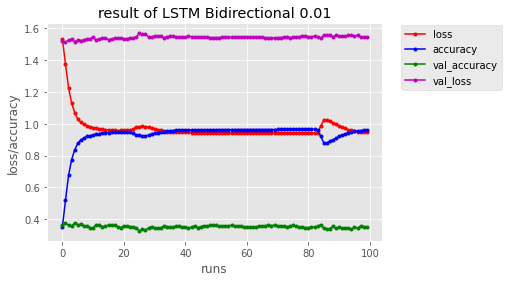

In [225]:
plt.xlabel("runs")
x_len=list(range(len(acc)))
plt.title('result of ' +model_type + ' '+ str(learning_rate))
plt.ylabel("loss/accuracy")
plt.plot(x_len, loss, 'r.-',label="loss")
plt.plot(x_len, acc, 'b.-', label="accuracy")
plt.plot(x_len, val_acc, 'g.-', label="val_accuracy")
plt.plot(x_len, val_loss_arr, 'm.-', label="val_loss")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.2)
plt.show

# Evaluations 


3. <br>
 1) According to the result for the RNN and LSTM was trained under having no drop outs with the fixed sized of <b>0.01</b>.<br>

    With out dropouts 
      >   RNN - overfited.<br>
      >   LSTM - converged to values low values. But with time the model overfits the model. 

    With dropouts
    > RNN and LSTM both coverged creating a plateau.

  Therefore Ill be using drop in the model to reduce the overfit. 
 Results images can be found in 
<font color="red"> 3_1.. </font>folders 


3. <br>
 2) Three learning rates were experimented under having same drop outs.

    * 0.001, 0.01, 0.1 learning rates were used to train the simulations.
    
    <b>RNN</b> <hr>
    *  RNN with learning rate of 0.1 exploded with having the lowest validation loss of 0.250.
    * RNN with learning rate of 0.001 didnt show that much improvment on the  validation set. validation loss was recorded as 0.334.
    * RNN with learning rate of <b>0.01</b> did converge and was contant over time. But it showed higher accuracy on test data set over 0.01 .Validation loss was recorded as 0.265.
    
    <b>LSTM</b><hr>

    * 0.1 learning rate overfited the  the training process.
    * 0.01 learning rate has the show better valdation rate than 0.001. It did has lower accuracy rate over test data set than the 0.1 learning rate. 
    * In terms of the training graphs better performance was aquired by 0.01 learning rate. 






3. <br>
 3) Next I trained the model having 2 layers for both RNN and LSTM Keeping the learning rate of 0.01 and dropout as 0.2 

  RNN
    > Double RNN recorded the validation 0.269 over time having higher improvment but had lower accuracy over test set. 

  LSTM
    >  Double layer LSTM  has higher valdiation than doubled RNN, but had higher accuracy over the test data set. 

  

3. <br>
 4) Based on the dev (valdiation set) 33.41% was the highest accuracy achieved by a model. The model is <B> RNN single layer model which has learening rate of 0.001 and 0.02 as drop out. </B>


3. <br>
 5) For the final experiment I created a bidirection lstm,which trains two  LSTM on one. This achieved the 0.35 validation loss over validation and the highest  accuaracy 37% over the test data set. It shows better improvement on the test data set over unidirectional network.

4. RNN model has higher F1 scores of LSTM. It does a better job in identifying the sequences.   